In [1]:
# #!/usr/bin/env python

# """Notebook for rapid prompt-based annotation. Box to mask using Segment Anything Model"""

# __author__      = "Sahib Julka <sahib.julka@uni-passau.de>"
# __copyright__   = "GPL"


In [2]:
import torch
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import sys
sys.path.append('../src')
from utils import encode_image
from jupyter_bbox_widget import BBoxWidget
import pandas as pd

import cv2
import numpy as np
import supervision as sv

In [3]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "/root/Master_Thesis/sam/sam_vit_h_4b8939.pth"

In [4]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_predictor = SamPredictor(sam)

In [5]:
df = pd.read_csv("/root/Master_Thesis/data/dataframes/brain_df_train.csv")
# df = pd.read_csv("/root/Master_Thesis/data/dataframes/fire_df_train.csv")

In [6]:
idxs = []
for i in range(len(df)):
    if os.path.isfile(df["oracle"][i]):
        idxs.append(i)
    
print(len(idxs))

215


In [7]:
idx = 0

0


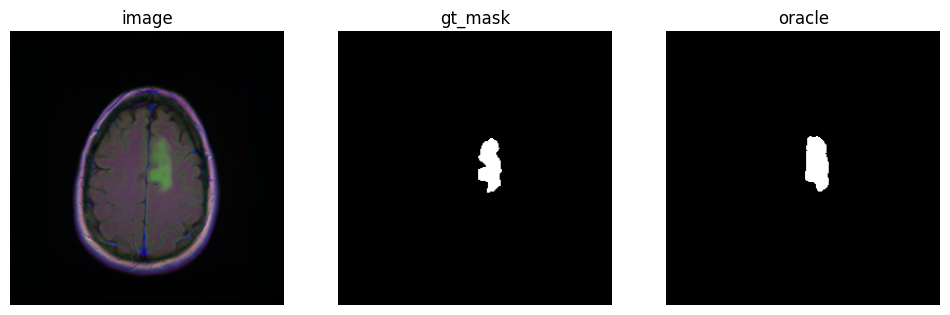

In [8]:
# good = [0, 1, 3, 4, 5, 8, 9, 13, 14, 16, 17, 19, 20, 24, 26, 29, 30, 33, 34, 35, 36, 42, 43, 45, ]
# bad = [2, 6, 7, 10, 11, 12, 15, 18, 21, 22, 23, 25, 27, 28, 31, 32, 37, 38, 39, 40, 41, 44, 46, ]
print(idx)
i = idxs[idx]

image = cv2.imread(df["images"][i])
gt_mask = cv2.imread(df["masks"][i])

oracle = np.load(df["oracle"][i])
oracle = np.reshape(oracle, (1, 256, 256))

sv.plot_images_grid(
    images=[image, gt_mask, oracle[0]],
    grid_size=(1, 3),
    titles=['image', 'gt_mask', 'oracle']
)
idx +=1            

In [9]:
type(oracle)

numpy.ndarray

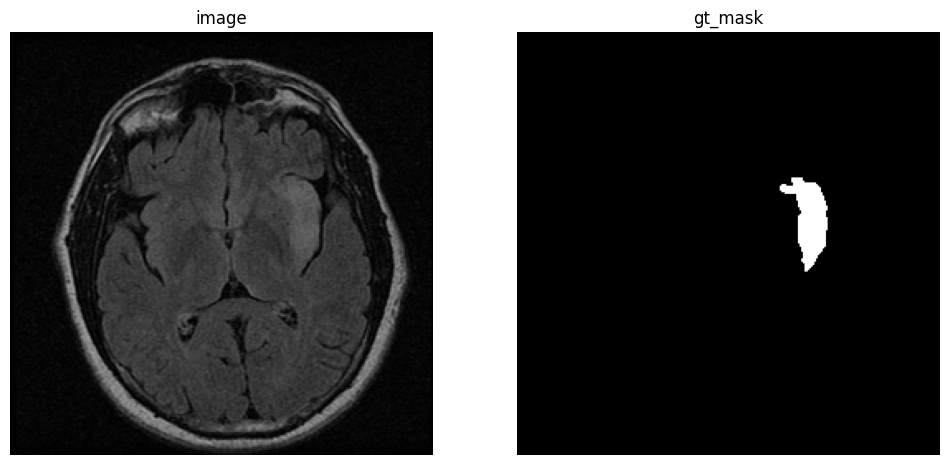

In [10]:
# i = np.random.randint(1, len(df))
i=5
import supervision as sv

image = cv2.imread(df["images"][i])
gt_mask = cv2.imread(df["masks"][i])
sv.plot_images_grid(
    images=[image, gt_mask],
    grid_size=(1, 2),
    titles=['image', 'gt_mask']
)

In [11]:
type(gt_mask)

numpy.ndarray

In [12]:
print(type(image))

# np.transpose(image, (2, 0 ,1)).shape

<class 'numpy.ndarray'>


In [13]:
# resized_image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_CUBIC)
# resized_mask = cv2.resize(gt_mask, (256, 256), interpolation=cv2.INTER_CUBIC)

# sv.plot_images_grid(
#     images=[resized_image, resized_mask],
#     grid_size=(1, 2),
#     titles=['resized_image', 'resized_mask']
# )

In [14]:
# print(resized_image.shape)

In [15]:
import imutils

# imgray = cv2.cvtColor(resized_mask, cv2.COLOR_BGR2GRAY)
imgray = cv2.cvtColor(gt_mask, cv2.COLOR_BGR2GRAY)
print(imgray.shape)
ret, thresh = cv2.threshold(imgray, 0.5, 1, 0)
print(thresh.shape)
# contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
cnts = []
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    box = np.array([x, y, x+w, y+h])
    cnts.append(box)

(256, 256)
(256, 256)


In [16]:
len(cnts)

1

In [17]:
def getAreas(cnts):
    return [(box[2]-box[0]) * (box[3] - box[1]) for box in cnts]

In [18]:
areas = getAreas(cnts)
areas

[1653]

In [25]:
M = cv2.moments(contours[0])
cX = int(M["m10"] / M["m00"])
cY= int(M["m01"] / M["m00"])

In [26]:
print(M)

{'m00': 773.5, 'm10': 136713.16666666666, 'm01': 87132.0, 'm20': 24186448.916666664, 'm11': 15417395.208333332, 'm02': 9968367.75, 'm30': 4282906229.3500004, 'm21': 2730427633.4, 'm12': 1765498167.8666666, 'm03': 1157762613.7, 'mu20': 22919.58243553713, 'mu11': 17147.45397005044, 'mu02': 153260.54379444197, 'mu30': -58010.08884763718, 'mu21': -150559.84115433088, 'mu12': -235905.20251477882, 'mu03': 333248.22256684303, 'nu20': 0.038307698885533405, 'nu11': 0.028660186335669705, 'nu02': 0.25615906307295677, 'nu30': -0.00348620350782105, 'nu21': -0.009048120021808716, 'nu12': -0.014177077830036027, 'nu03': 0.020027052975889015}


In [27]:
print(cX, cY)

176 112


In [74]:
def getBoxes(image, gt_mask):
    # gt_mask = gt_mask.sum(axis = 2)
    # gt_mask = np.reshape(gt_mask, (gt_mask.shape[0], gt_mask.shape[1], -1))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask_gray = cv2.cvtColor(gt_mask, cv2.COLOR_BGR2GRAY)
    # mask_gray = gt_mask
    ret, thresh = cv2.threshold(mask_gray, 0.5, 1, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        box = np.array([x, y, x+w, y+h])
        cnts.append(box)
    boxes = torch.Tensor(np.array(cnts)).to(DEVICE)
    transformed_boxes = mask_predictor.transform.apply_boxes_torch(boxes, image_rgb.shape[:2])
    return transformed_boxes                                                                                                                           
    

In [19]:
print(len(cnts))

2


In [21]:
boxes = np.array(cnts)

In [22]:
boxes = torch.Tensor(boxes).to(DEVICE)
# image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print("image_rgb.shape : ", image_rgb.shape)

mask_predictor.set_image(image_rgb)
transformed_boxes = mask_predictor.transform.apply_boxes_torch(boxes, image_rgb.shape[:2])


masks, scores, logits = mask_predictor.predict_torch(
    point_coords = None,
    point_labels = None,
    boxes=transformed_boxes,
    multimask_output=False
)
mask = masks.sum(axis = 0).cpu().numpy()

image_rgb.shape :  (256, 256, 3)


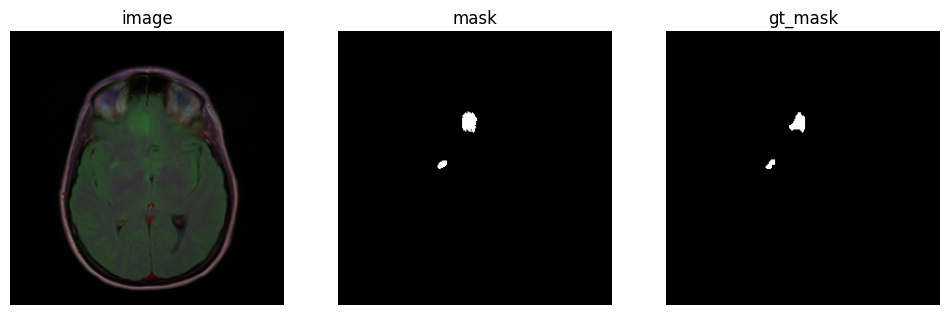

In [23]:
sv.plot_images_grid(
    #images=[image_rgb, mask[0], resized_mask],
    images=[image_rgb, mask[0], gt_mask],
    grid_size=(1, 3),
    titles=['image', 'mask', 'gt_mask']
)

In [24]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
# mask_annotator = sv.MaskAnnotator(color=sv.Color.red())
# mask_annotator = sv.MaskAnnotator(color=sv.Color(r=255, g=0, b=0))
mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup="INDEX")

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=mask),
    mask=mask
)
detections = detections[detections.area == np.max(detections.area)]

# source_image = box_annotator.annotate(scene=resized_image.copy(), detections=detections, skip_label=True)
# segmented_image = mask_annotator.annotate(scene=resized_image.copy(), detections=detections)

source_image = box_annotator.annotate(scene=image.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image.copy(), detections=detections)


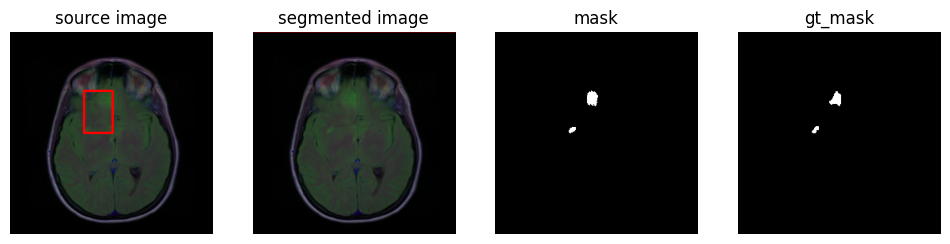

In [25]:
sv.plot_images_grid(
    # images=[source_image, segmented_image, mask[0], resized_mask],
    images=[source_image, segmented_image, mask[0], gt_mask],
    grid_size=(1, 4),
    titles=['source image', 'segmented image', 'mask', 'gt_mask']
)

In [62]:
images = []
masks=[]
i = 0
num =0

while i < len(df) and num <5:
    mask = cv2.imread(df["masks"][i])
    if mask.sum() != 0:
        masks.append(mask)
        images.append(cv2.imread(df["images"][i]))        
        num+=1
    i+=1

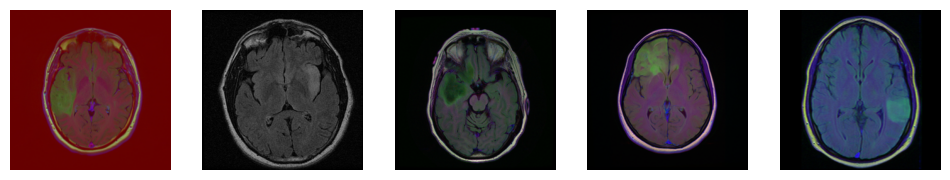

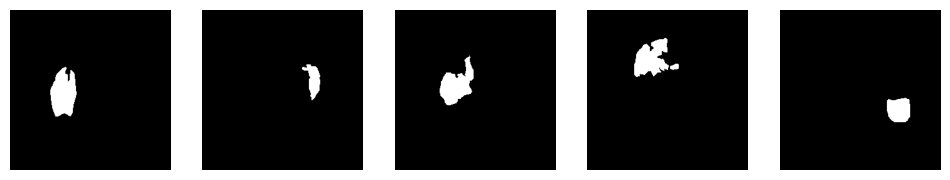

In [63]:
sv.plot_images_grid(
    images=images,
    grid_size=(1, len(images)),
)

sv.plot_images_grid(
    images=masks,
    grid_size=(1, len(masks)),
)

In [54]:
masks[0].shape

(256, 256, 3)

In [80]:
from segment_anything.utils.transforms import ResizeLongestSide
resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

def prepare_image(image, transform, device):
    image = transform.apply_image(image)
    image = torch.as_tensor(image, device=device) 
    return image.permute(2, 0, 1).contiguous()

In [81]:
batched_input = [
     {
         'image': prepare_image(images[0], resize_transform, DEVICE),
         'boxes': getBoxes(images[0], masks[0]),
         'original_size': images[0].shape[:2]
     },
     {
         'image': prepare_image(images[1], resize_transform, DEVICE),
         'boxes': getBoxes(images[1], masks[1]),
         'original_size': images[1].shape[:2]
     }
]

In [82]:
batched_output = sam(batched_input, multimask_output=False)

In [103]:
batched_output[0].keys()
output_masks=[]
for i in range(len(batched_output)):
    for mask in batched_output[i]["masks"]:
        mask = mask.sum(axis = 0).cpu().numpy()
        output_masks.append(mask)

In [104]:
output_masks[0].shape

(256, 256)

In [112]:
import torch.nn.functional as F
out = torch.rand((256, 1, 256, 256))
prob = F.sigmoid(out)

SyntaxError: invalid syntax (3383273082.py, line 1)

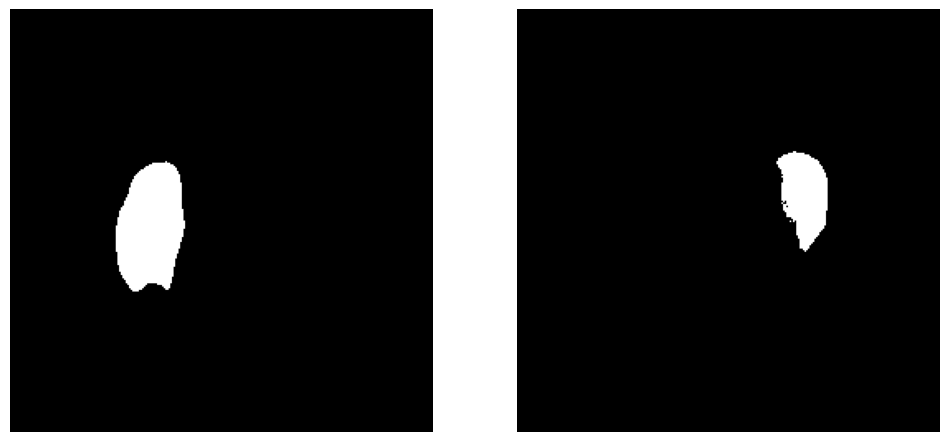

In [106]:
sv.plot_images_grid(
    images=output_masks,
    grid_size=(1, 2),
)

In [ ]:
# box_annotator = sv.BoxAnnotator(color=sv.Color.red())
# # mask_annotator = sv.MaskAnnotator(color=sv.Color.red())
# # mask_annotator = sv.MaskAnnotator(color=sv.Color(r=255, g=0, b=0))
# mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup="INDEX")

# detections = sv.Detections(
#     xyxy=sv.mask_to_xyxy(masks=mask),
#     mask=mask
# )
# detections = detections[detections.area == np.max(detections.area)]

# source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
# segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

# sv.plot_images_grid(
#     images=[source_image, segmented_image],
#     grid_size=(1, 2),
#     titles=['source image', 'segmented image']
# )

In [69]:
# import supervision as v

# sv.plot_images_grid(
#     images=mask,
#     grid_size=(1, 2),
#     size=(16, 4)
# )

In [366]:
# os.makedirs("../data/processed/masks+/", exist_ok = True)
# np.save('../data/processed/masks+/{}.npy'.format(filenames[i].split('.png')[0]), mask)

In [ ]:
class SAMOracle():
    
    def __init__(self,
                 device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
                 model_type = "vit_h",
                 checkpoint_path = os.path.join("../sam","sam_vit_h_4b8939.pth"),
                 model = None,
                 default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}
                ):
        
        self.device = device
        self.model_type = model_type
        self.checkpoint_path = checkpoint_path
        self.model = sam_model_registry[model_type](checkpoint=checkpoint_path).to(device=device)
        self.mask_predictor = SamPredictor(self.model)
        self.default_box = default_box        
        
        
    
    def get_mask(self, img_path = None, img_rgb=None, boxes=None):
        
        if img_rgb is None:
            image_bgr = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
            
        self.mask_predictor.set_image(img_rgb)
        
        if boxes is None:
            widget = BBoxWidget()
            widget.image = encode_image(img_path)
            boxes = []
            for box in widget.bboxes:
                box = np.array([
                    box['x'], 
                    box['y'], 
                    box['x'] + box['width'], 
                    box['y'] + box['height']
                ])
                boxes.append(box)
            boxes.append(np.array([
                        self.default_box['x'],
                        self.default_box['y'],
                        self.default_box['x'] + self.default_box['width'],
                        self.default_box['y'] + self.default_box['height']]))
            boxes = torch.Tensor(boxes).to(self.device)
        transformed_boxes = self.mask_predictor.transform.apply_boxes_torch(boxes, img_rgb.shape[:2])


        masks, scores, logits = self.mask_predictor.predict_torch(
            point_coords = None,
            point_labels = None,
            boxes=transformed_boxes,
            multimask_output=False
        )
        mask = masks.sum(axis = 0).cpu().numpy()
        return mask
    
    def annotate_mask(self, img_path:str):
        widget = BBoxWidget()
        widget.image = encode_image(img_path)
        boxes = []
        for box in widget.bboxes:
            box = np.array([
                box['x'], 
                box['y'], 
                box['x'] + box['width'], 
                box['y'] + box['height']
            ])
            boxes.append(box)
        boxes.append(np.array([
                    self.default_box['x'],
                    self.default_box['y'],
                    self.default_box['x'] + self.default_box['width'],
                    self.default_box['y'] + self.default_box['height']]))
        boxes = torch.Tensor(boxes).to(self.device)

        image_bgr = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        mask_annotator = sv.MaskAnnotator(color=sv.Color.red())
        mask = self.get_mask(img_rgb=img_rgb, boxes=boxes)
        detections = sv.Detections(xyxy=sv.mask_to_xyxy(masks=mask),
                                   mask=mask)
        
        detections = detections[detections.area == np.max(detections.area)]

        segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)
        return segmented_image